In [ ]:
!pip install tensorflow==2.7.0
!pip install tensorflow-quantum==0.7.2

In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [3]:
x_train = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
x_test = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

In [4]:
# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train = (x_train - 127.5)/127.5
x_test = (x_test - 127.5)/127.5

print("Number of training examples:", len(x_train))
print("Number of test examples:", len(x_test))

Number of training examples: 60000
Number of test examples: 10000


5


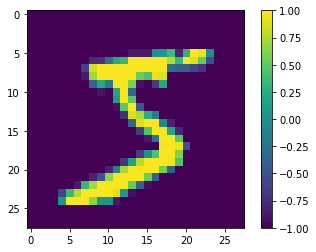

In [5]:
print(train_labels[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

In [8]:
x_train_small = tf.image.resize(x_train, (4,4,)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

5


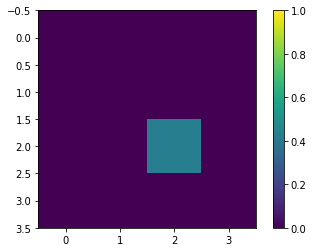

In [9]:
print(train_labels[0])
plt.imshow(x_test_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [10]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_small > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

In [12]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4,4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

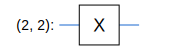

In [13]:
SVGCircuit(x_train_circ[0])

array([[2, 2]])

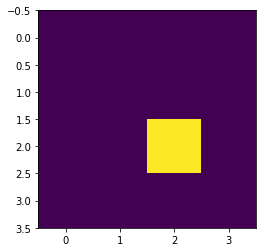

In [14]:
bin_img = x_train_bin[0,:,:,0]
plt.imshow(bin_img)
indices = np.array(np.where(bin_img)).T
indices

In [15]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

In [16]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout

    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

In [70]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()

    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))

    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).

    builder.add_layer(circuit, cirq.CX, "cx")
    builder.add_layer(circuit, cirq.ZZ,"zz")
    builder.add_layer(circuit, cirq.XX,"xx")
    # builder.add_layer(circuit, cirq.CX,"cx")
    # builder.add_layer(circuit, cirq.H)
    # builder.add_layer(circuit, cirq.ZZ,"zz")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))
    # a = SVGCircuit(circuit)
    return circuit, cirq.Z(readout)

In [71]:
model_circuit, model_readout = create_quantum_model()

In [72]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

In [73]:
train_labels_hinge = 2.0*train_labels-1.0
test_labels_hinge = 2.0*test_labels-1.0

In [74]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [75]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc_1 (PQC)                 (None, 1)                 48        
                                                                 
Total params: 48
Trainable params: 48
Non-trainable params: 0
_________________________________________________________________
None


In [1]:
EPOCHS = 4
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

NameError: ignored

In [77]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
train_labels_hinge_sub = train_labels_hinge[:NUM_EXAMPLES]

In [ ]:
qnn_history = model.fit(
      x_train_tfcirc_sub, train_labels_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, test_labels_hinge))

qnn_results = model.evaluate(x_test_tfcirc, test_labels_hinge)

Epoch 1/10
1875/1875 [==============================] - 4866s 3s/step - loss: 0.3717 - hinge_accuracy: 0.8780 - val_loss: 0.2224 - val_hinge_accuracy: 0.8949
Epoch 2/10
1875/1875 [==============================] - 4857s 3s/step - loss: 0.1895 - hinge_accuracy: 0.8984 - val_loss: 0.1639 - val_hinge_accuracy: 0.9012
Epoch 3/10
 780/1875 [===========>..................] - ETA: 45:59 - loss: 0.1749 - hinge_accuracy: 0.8976